In [1]:
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
import os
os.chdir('..')

import main
drive_path = r"U:\VEIDB/"
data_path = r"V:\Data"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
from datetime import date
import numpy as np
from scipy.signal import convolve, medfilt
from scipy import ndimage
import pandas as pd
from pathlib import Path
from matplotlib.gridspec import GridSpec
import matplotlib
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesResampler

import seaborn as sb
sb.set_style('white')

In [3]:
# Import local Neuron project
import sys
projects_folder = r'C:\Users\bramn\Documents\Projects'
if os.path.abspath(projects_folder) not in sys.path:
    sys.path.append(os.path.abspath(projects_folder))

import Neuron
from Neuron.datatypes.block import Block
from Neuron.visualization import spikes as vis_spikes
from ephys.neuropixels_utils import get_ap_analog
from Neuron.stages import stage
from Neuron.stages.pipeline import Pipeline
from Neuron.stages.firing_rate_estimation import FiringRateEstimation
from Neuron.stages.downsampling import Downsampling

In [4]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()
lfp_table = ft.ephys_tables.LFP()
opto_table = ft.event_tables.OptoEvents()

In [5]:
""" Parameters """
key = {'experiment_id': '01589', 'session_id': '20211022', 'subsession_type': 'SWEP'}
# key = {'experiment_id': '01231', 'session_id': '20211020', 'subsession_type': 'EXPA'}

sSC_surface = 2100
stims_vis = ['EXPA', 'EXBA', 'DIMM', 'CHPE', 'SWEP']


figures_folder = os.path.join(r"C:\Users\bramn\Documents\Projects\DatajointVEIDB\images", f"neurons_{key['experiment_id']}_{key['session_id']}")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)


In [6]:
unit_info, units = (subsess_spikes_table & key).fetch1('cluster_info', 'clusters')
block = Block(units_dict=units, unit_info=unit_info).annot_slice(annot='good').unit_slice([170]) # 10
block.remap_depth(sSC_surface, reverse=False)

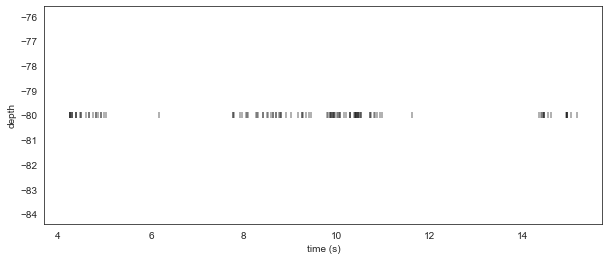

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
vis_spikes.plot_raster(block.time_slice(0, 1000*16), ax, visualize_depth=True)
plt.show()

In [8]:
from scipy.signal import convolve

u_spiketimes = block.units[170].views['spikes']
u_spikes = np.zeros(shape=(int(u_spiketimes[-1])+1))
u_spikes[u_spiketimes] = 1

(0.0, 30.0)

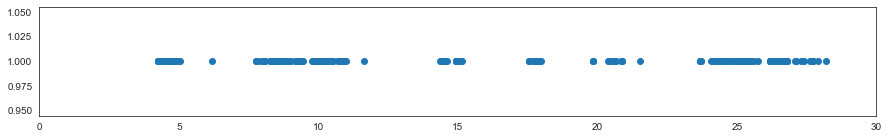

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.scatter(u_spiketimes/30000, np.ones(len(u_spiketimes)))
plt.xlim(0, 30)

4.252566666666667


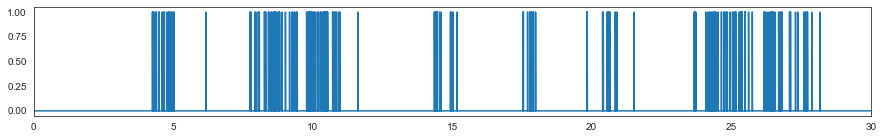

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(np.arange(0, len(u_spikes))/30000, u_spikes)
plt.xlim(0, 30)

print(np.where(u_spikes > 0)[0][0]/30000)

4.2276


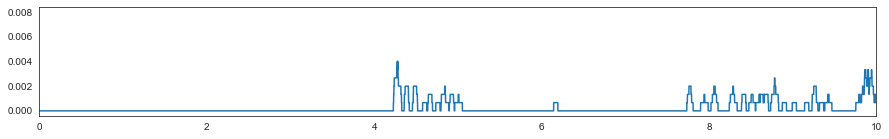

In [11]:
kernel = np.ones(30*50)/(30*50)
u_spikes_sliding_counts = convolve(u_spikes, kernel, 'same')

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(np.arange(0, len(u_spikes_sliding_counts))/30000, u_spikes_sliding_counts)
plt.xlim(0, 10)

print(np.where(u_spikes_sliding_counts > 0.000001)[0][0]/30000)

4.2526
4.3


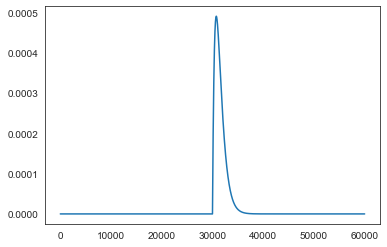

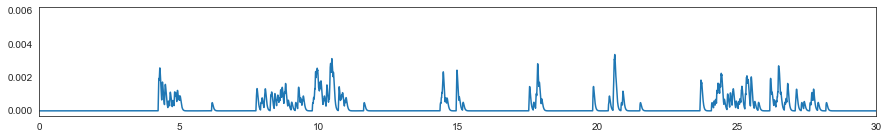

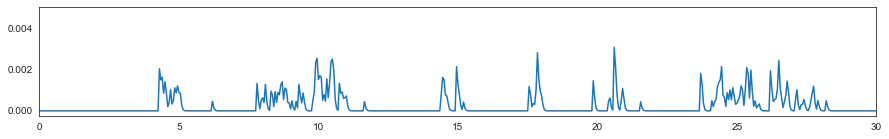

In [12]:
window = np.arange(-30000, 30001, 1)
alpha = 2/(30*50)
kernel = (alpha**2)*window*np.exp(-alpha*window)
kernel[:len(window)//2] = 0
plt.plot(kernel)
u_spikes_sliding_counts = convolve(u_spikes, kernel, 'same')
u_spikes_sliding_counts_subsamp = np.squeeze(TimeSeriesResampler(sz=len(u_spikes_sliding_counts)//(30*50)).fit_transform(u_spikes_sliding_counts))

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(np.arange(0, len(u_spikes_sliding_counts))/30000, u_spikes_sliding_counts)
plt.xlim(0, 30)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(np.arange(0, len(u_spikes_sliding_counts_subsamp))/20, u_spikes_sliding_counts_subsamp)
plt.xlim(0, 30)

print(np.where(u_spikes_sliding_counts > 0.000001)[0][0]/30000)
print(np.where(u_spikes_sliding_counts_subsamp > 0.000001)[0][0]/20)

In [40]:
hz = 100
sigma = 30*50

line = Pipeline()
line.add_stage(FiringRateEstimation(fr_type='causal'), sigma=sigma, hz=hz) # 30*25 ==> hz=40
fr = line.execute(block.get_view('spikes'), meta=None)[-1]
block.add_view('fr', fr, hz=hz)

In [41]:
fr.shape

(1, 19260)

In [42]:
u_spikes_fr = block[170].views['fr']


In [43]:
block.get_view('spikes')[0, -1]

5778165

In [44]:
u_spikes_fr.shape

(19260,)

In [45]:
u_spikes_fr

array([-2.43670348e-19, -9.95861318e-20, -1.61597003e-19, ...,
        2.73577819e-20,  1.11960952e-19,  3.02151232e-19])

4.26


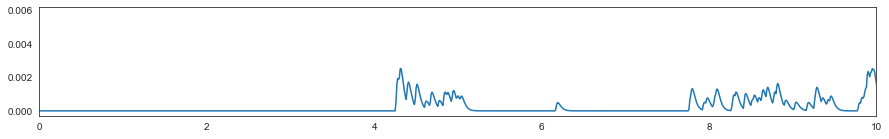

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(np.arange(0, len(u_spikes_fr))/hz, u_spikes_fr) # /hz
plt.xlim(0, 10)
print(np.where(u_spikes_fr > 0.000001)[0][0]/hz) # /hz

4.26


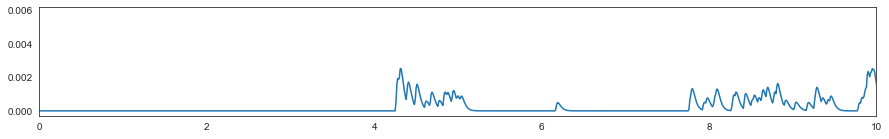

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(np.arange(0, len(u_spikes_fr))/hz, u_spikes_fr) # /hz
plt.xlim(0, 10)
print(np.where(u_spikes_fr > 0.000001)[0][0]/hz) # /hz